<center> <img src="https://pjreddie.com/media/image/yologo_2.png" width="600"/> </center>

<a id="section-one"></a>
## 1. Import the libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time
import os
import shutil
import torchvision.transforms as T
from PIL import Image

In [ ]:
TRAIN_FOLDER = "/kaggle/input/happy-whale-and-dolphin/train_images/"
TEST_FOLDER = "/kaggle/input/happy-whale-and-dolphin/test_images/"
# Import the training data
traindata = pd.read_csv("/kaggle/input/happy-whale-and-dolphin/train.csv")
traindata.loc[:,'image'] = TRAIN_FOLDER + traindata['image']
# Import the test data
testdata = pd.read_csv("/kaggle/input/happy-whale-and-dolphin/sample_submission.csv")
testdata.loc[:,'image'] = TEST_FOLDER + testdata['image']

outputdir = '/kaggle/working/'

if not os.path.exists(outputdir+"/train_images/"):
    os.makedirs(outputdir+"/train_images/")
    
if not os.path.exists(outputdir+"/test_images/"):
    os.makedirs(outputdir+"/test_images/")
    

original = r'/kaggle/input/happy-whale-and-dolphin/train.csv'
target = r'./train.csv'
shutil.copyfile(original, target)

original = r'/kaggle/input/happy-whale-and-dolphin/sample_submission.csv'
target = r'./sample_submission.csv'
shutil.copyfile(original, target)

<a id="section-two"></a>
## 2. Load YOLO.

There are a few different YOLO models. The smaller ones are faster, but are not as accurate.

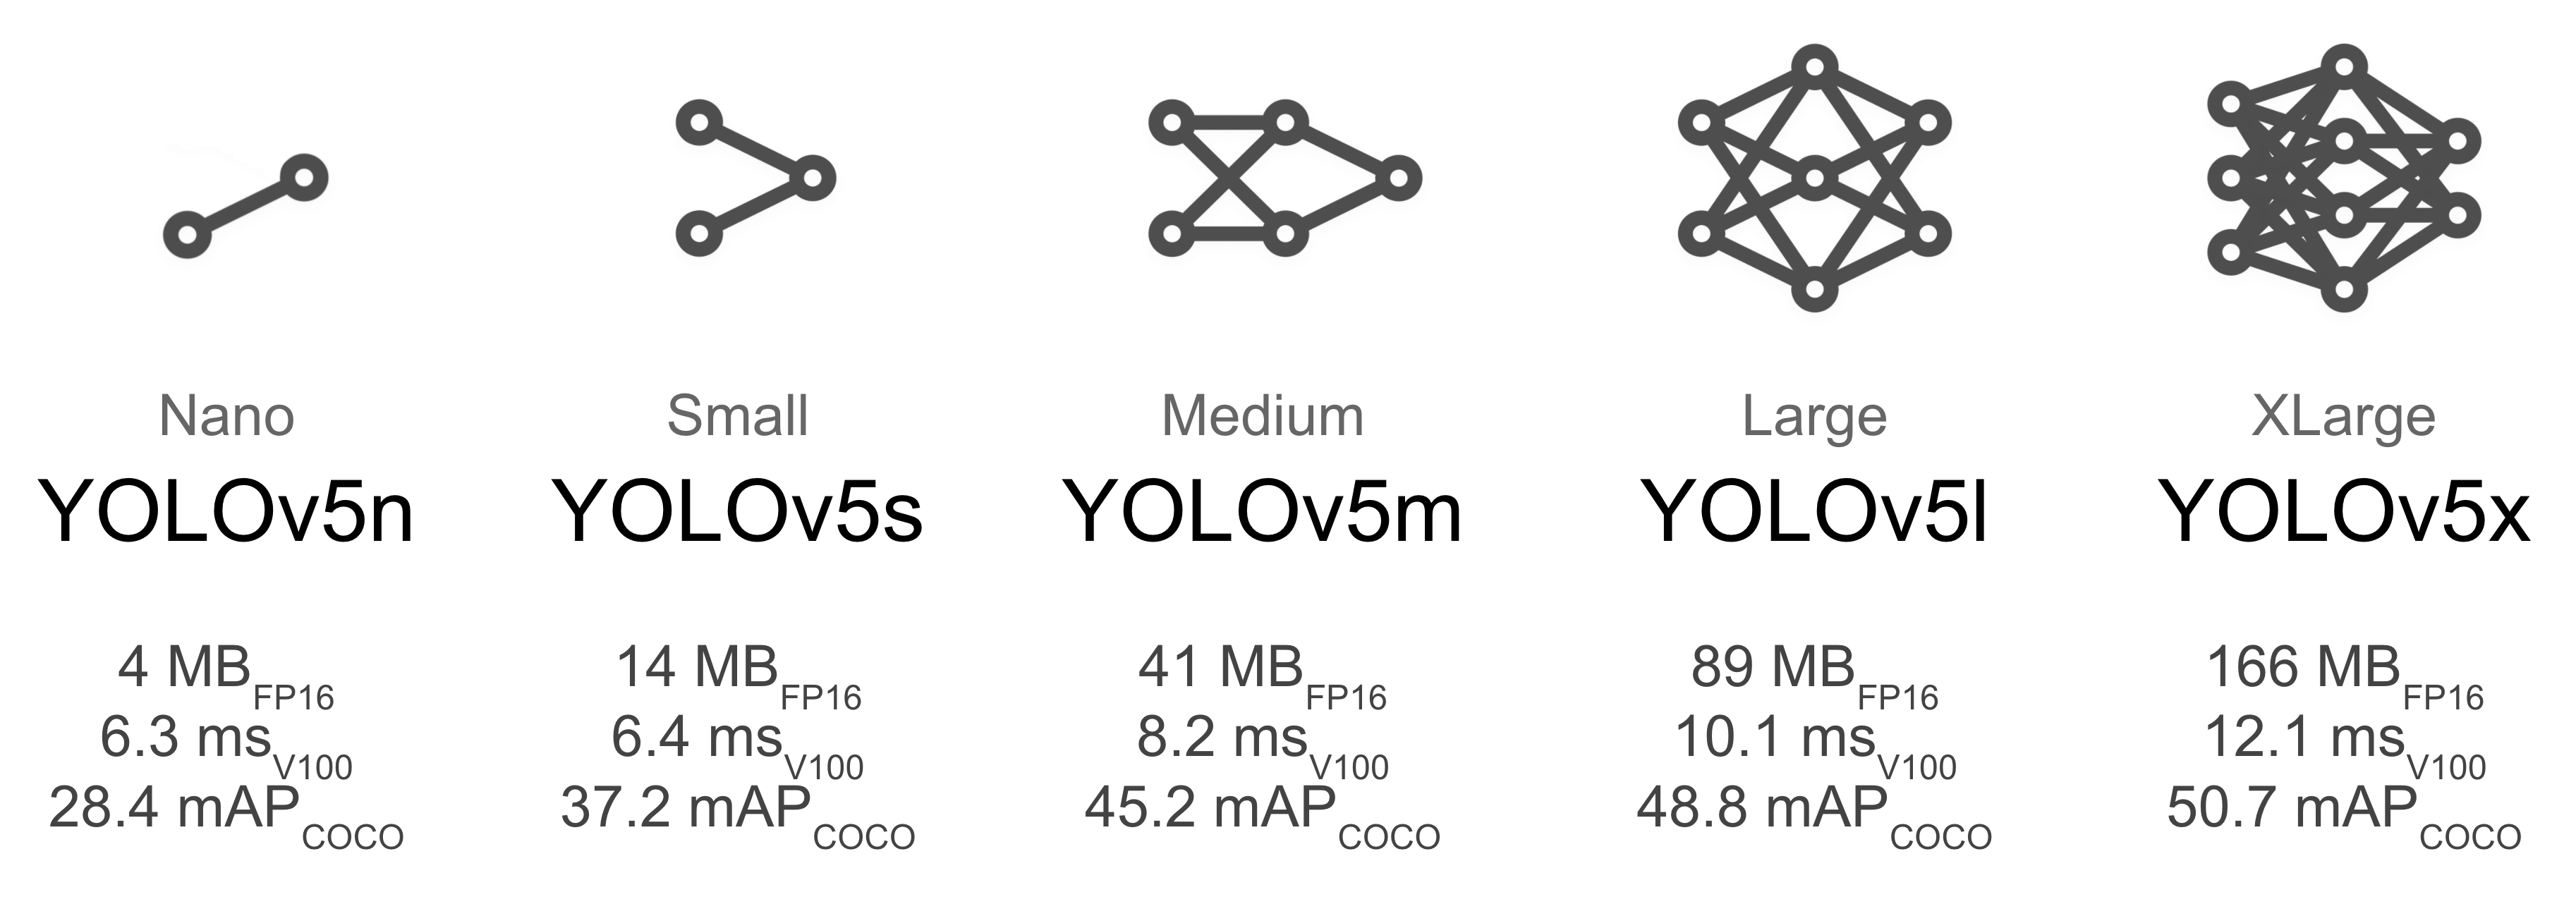

<center> <img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/model_plot.png" width="800"/>  </center>

|Model |size<br><sup>(pixels) |mAP<sup>val<br>0.5:0.95 |mAP<sup>test<br>0.5:0.95 |mAP<sup>val<br>0.5 |Speed<br><sup>V100 (ms) | |params<br><sup>(M) |FLOPS<br><sup>640 (B)
|---   |---  |---        |---         |---             |---                |---|---              |---
|[YOLOv5s6](https://github.com/ultralytics/yolov5/releases)   |1280 |43.3     |43.3     |61.9     |**4.3** | |12.7  |17.4
|[YOLOv5m6](https://github.com/ultralytics/yolov5/releases)   |1280 |50.5     |50.5     |68.7     |8.4     | |35.9  |52.4
|[YOLOv5l6](https://github.com/ultralytics/yolov5/releases)   |1280 |53.4     |53.4     |71.1     |12.3    | |77.2  |117.7
|[YOLOv5x6](https://github.com/ultralytics/yolov5/releases)   |1280 |**54.4** |**54.4** |**72.0** |22.4    | |141.8 |222.9
|[YOLOv5x6](https://github.com/ultralytics/yolov5/releases) TTA |1280 |**55.0** |**55.0** |**72.0** |70.8 | |-  |-

<details>
  <summary>Table Notes (click to expand)</summary>

<a id="section-three"></a>

## 3. Load the YOLO model

I included a "crop" helper function. 

In [ ]:
import torch
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True) #Choose from yolov5n yolov5s yolov5m yolov5l yolov5x


def crop(model, im_file):
    """Use expectation maximization to update all training classification
       labels.
    Parameters
    ----------
    model : torch model object
        YOLO model chosen from : yolov5n yolov5s yolov5m yolov5l yolov5x

    im_file : str
        Full directory of image file to be YOLO'd and cropped.        

    Returns
    -------
    image : np.ndarray, shape=(length,width,channels)
        Cropped image that includes objects from every bounding box
    """
    results = model([im_file])
    #results.pandas().xyxy[0]
    results = results.pandas().xyxy[0]
    try:
        xmin, xmax, ymin, ymax = int(results.xmin.min()), int(results.xmax.max()), int(results.ymin.min()), int(results.ymax.max())
        return Image.fromarray(cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)[ymin:ymax][:,xmin:xmax]), results
    #If no objects are detected, return the original image.
    except ValueError:
        return Image.fromarray(cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)), pd.DataFrame()    
    

In [ ]:
def progress_bar(perc_comp):
    '''
    Takes float or int between 0 and 100. 
    '''
    bar_width = 100
    bar = '#' * int(perc_comp)
    bar += '-' * (100-int(perc_comp)) + ' ' + str(int(perc_comp)) + '% complete'
    if perc_comp < 100:
        print (bar, end='\r')
    else:
        print (bar)
        
def timer_func(func):
    '''
    This function shows the execution time of the function object passed
    '''
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

<a id="section-four"></a>

## 4. Process the training set

In [ ]:
from time import time

t1 = time()
train_annotations = pd.DataFrame()
for i in range(len(traindata.image.values)):
    output = outputdir+"/train_images/"+traindata.image.values[i].split('/')[-1]
    img, df = crop(yolo, traindata.image.values[i])
    img = T.functional.center_crop(img, (max(img.size),max(img.size)))
    img = T.functional.resize(img,size=(700,700))
    if len(df)>0:    
        train_annotations = train_annotations.append(pd.DataFrame(df.values,
                            columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name'], 
                            index=[traindata.image.values[i]]*len(df)))
    else:    
        train_annotations = train_annotations.append(pd.DataFrame(df.values,
                            ))
    img.save(output)
    progress_bar(i/(len(traindata.image.values)-1)*100)   
t2 = time()
print(f'Executed in {(t2-t1):.4f}s')

train_annotations.to_csv('training_annotations.csv')

<a id="section-five"></a>

## 4. Process the test set

In [ ]:
from time import time

t1 = time()
test_annotations = pd.DataFrame()
for i in range(len(testdata.image.values)):
    output = outputdir+"/test_images/"+testdata.image.values[i].split('/')[-1]
    img, df = crop(yolo, testdata.image.values[i])
    img = T.functional.center_crop(img, (max(img.size),max(img.size)))
    img = T.functional.resize(img,size=(700,700))
    if len(df)>0:    
        train_annotations = test_annotations.append(pd.DataFrame(df.values,
                            columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name'], 
                            index=[testdata.image.values[i]]*len(df)))
    else:    
        train_annotations = test_annotations.append(pd.DataFrame(df.values,
                            ))
    img.save(output)
    progress_bar(i/(len(testdata.image.values)-1)*100)   
t2 = time()
print(f'Executed in {(t2-t1):.4f}s')

<a id="section-four"></a>
## 4. Conclusion

Automated cropping does seem to help or at least not be deleterious in most cases. In some cases YOLO overcrops and removes potentially useful information.

Please comment, and let me know how I can improve deleterious cropping. Thank you all!

<a id="section-five"></a>
## 5. References

[PyTorch implementation of YOLO](https://pytorch.org/hub/ultralytics_yolov5/)

[Happywhale - Whale and Dolphin Identification](https://www.kaggle.com/c/happy-whale-and-dolphin)